<a href="https://colab.research.google.com/github/Passionatelytoooadorable/Titanic/blob/main/Titanic_Prediction_Using_Random_Forest_%26_AdaBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T062149Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50b1fd0bc8d913510dd74ac70a31559b8b55f698f36deef09174fde5d28016cca33ffc8ab98cd730325889845b62c8b9b510a06465d23cea6e884743570da7458e18e9818d066e632e1997b627f1cfcae0556afbbfdf80440a6d7d5d0dd2536405a4e92bbd0faa47624ed08cbc2cca7bb2b43ccacfe017df57a6afc8a91ce999f22f1ee7b59b073a05f675de62e031657a250687e56c04fd4b4503bea52785a538ea3d2ea55b0b76cf6cc59220e810aa758cc3a5bcf073e229166f71edeb5ae1672bd627fcbf01a7def6905a929537a280ce505e41fb6eb66e5b68c5aee1711021bb3efc4d819c81ebed584328e905f24957b7bddd75a879f3ecfa30cf5165ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34877 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
titanic = pd.read_csv('/kaggle/input/titanic/train.csv')
titanic.head()
## checking the head of our data set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()
## checking info of all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic.shape
## checking shape of data set

In [7]:
titanic.describe()
## statistical information about numerical variable

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# **Data Quality Check**

handling missing values as well


In [8]:
round(100*(titanic.isnull().sum()/len(titanic)),2)
## checking missing value percentage in all columns

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

In [9]:
titanic.drop('Cabin',axis=1,inplace=True)
## cabin almost have 77% of missing values hence remove this column from data set

In [10]:
age_median = titanic['Age'].median(skipna=True)
titanic['Age'].fillna(age_median,inplace=True)
## as there is 19% of missing values in age column hence it is not a good idea to remove this row wise or column wise hence impute those missing values with the median of age


In [11]:
titanic = titanic[titanic['Embarked'].isnull()!=True]
## as embarked has a very small amount of missing values hence remove those rows which have missing values in embarked column


In [12]:
titanic.shape
## checking shape after removing null values

(889, 11)

# duplicate check

In [13]:
titanic_dub = titanic.copy()
## creating copy of the data frame to check duplicate values

In [14]:
titanic_dub.shape
## comparing shapes of two data frames

(889, 11)

In [15]:
titanic.shape
## shape of original data frame

(889, 11)

# EDA

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
## importing libraries for data visualitation

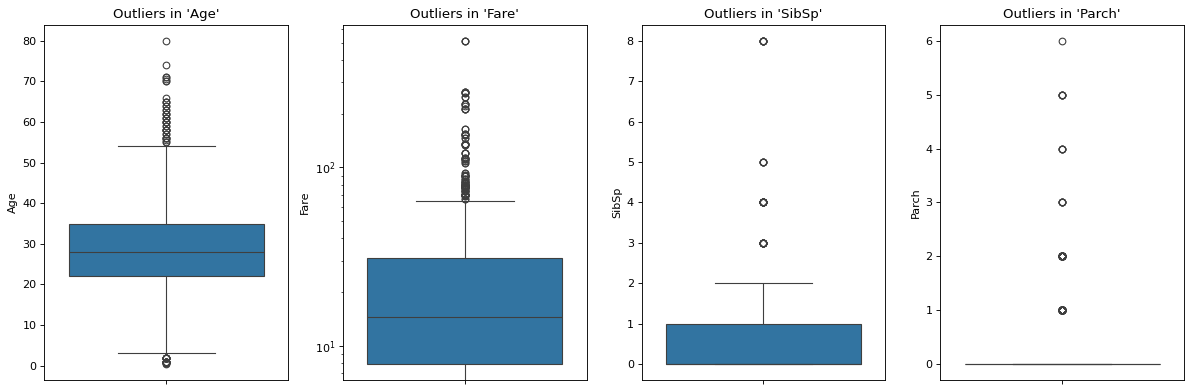

In [17]:
plt.figure(figsize=(15,5), dpi=80)
plt.subplot(1,4,1)
sns.boxplot(y=titanic['Age'])
plt.title("Outliers in 'Age'")

plt.subplot(1,4,2)
ax = sns.boxplot(y=titanic['Fare'])
ax.set_yscale('log')
plt.title("Outliers in 'Fare'")

plt.subplot(1,4,3)
sns.boxplot(y=titanic['SibSp'])
plt.title("Outliers in 'SibSp'")


plt.subplot(1,4,4)
sns.boxplot(y=titanic['Parch'])
plt.title("Outliers in 'Parch'")
#ax.set_yscale('log')
plt.tight_layout()
plt.show()

## plotting all four variables to check for outliers
## it clearly shows that all four variables has some outliers

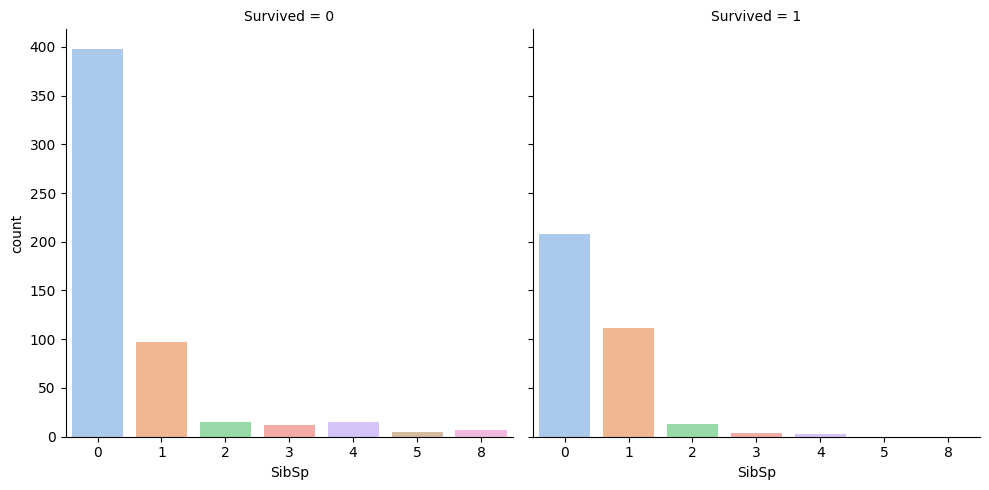

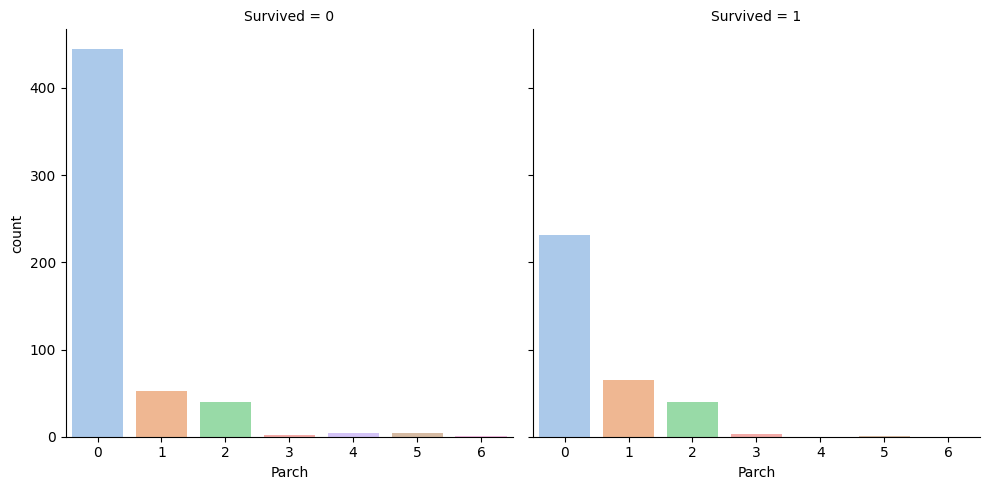

In [18]:


sns.catplot(x="SibSp", col = 'Survived', data=titanic, kind = 'count', palette='pastel')
sns.catplot(x="Parch", col = 'Survived', data=titanic, kind = 'count', palette='pastel')
plt.tight_layout()
plt.show()

## plotting of sibsp and parch in basis of survived and not survived

sibsp and parch basically tells us that whether a person is accompanied by someone else or not
so we can make two category by merging them to find whether a single person is acompanied by some one else or not

In [20]:
def alone(x):
    if (x['SibSp']+x['Parch']>0):
        return (1)
    else:
        return (0)
titanic['Alone'] = titanic.apply(alone,axis=1)
## creating a function to make one variable which tells us whether a person is single or accompanied by some on the ship

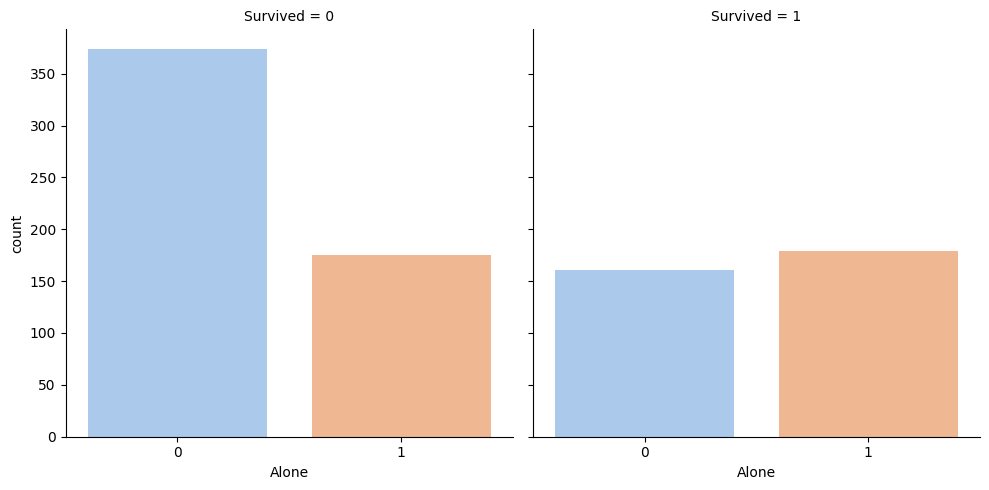

In [21]:
sns.catplot(x="Alone", col = 'Survived', data=titanic, kind = 'count', palette='pastel')
plt.show()

it clearly shows that those person who are not alone survived more

In [22]:
## drop parch and sibsp
titanic = titanic.drop(['Parch','SibSp'],axis=1)
titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,0


In [ ]:
sns.distplot(titanic['Fare'])
plt.show()

there is some skewness in the fare column
hence removing the skewness using log function

In [23]:
titanic['Fare'] = titanic['Fare'].map(lambda x: np.log(x) if x>0 else 0)
## converting fare into a logarithmic scale

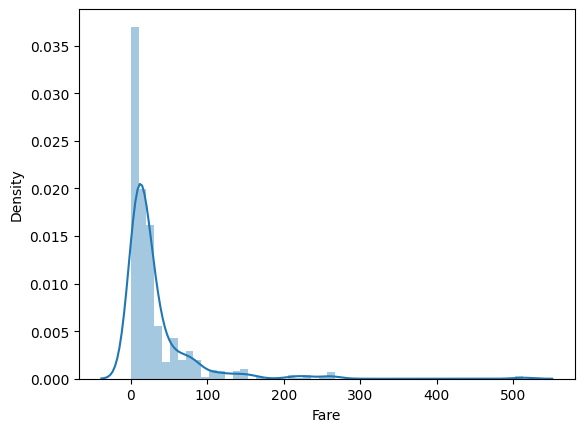

In [19]:
sns.distplot(titanic['Fare'])
plt.show()
## again check the distribution of fare

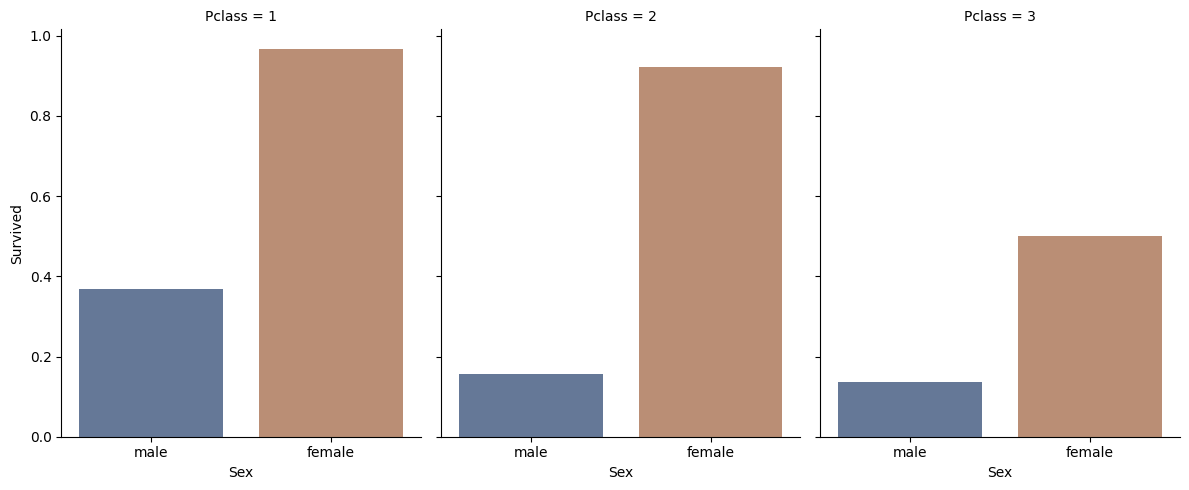

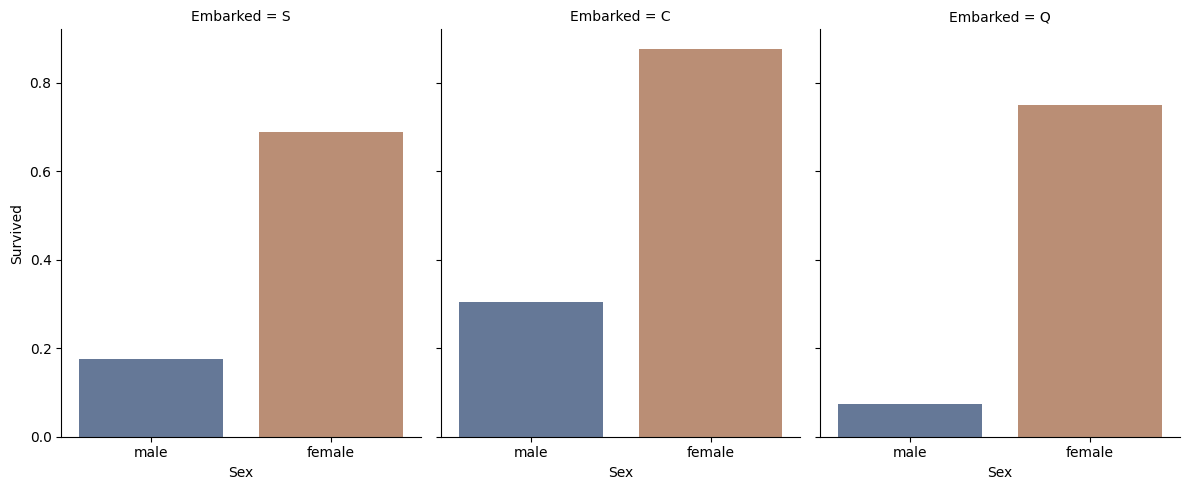

In [24]:
sns.catplot(x="Sex", y="Survived", col="Pclass", data=titanic, saturation=.5, kind="bar", ci=None, aspect=0.8, palette='deep')
sns.catplot(x="Sex", y="Survived", col="Embarked", data=titanic, saturation=.5, kind="bar", ci=None, aspect=0.8, palette='deep')
plt.show()

## plotting of survive on basis of pclass

females are more likely to be survived

In [25]:
survived_0 = titanic[titanic['Survived']==0]
survived_1 = titanic[titanic['Survived']==1]
## divided our dataset into survived or not survived to check the distribution of age in both the cases

In [26]:
survived_0.shape
## checking shape of the data set that contains the data of passengers who not survived

(549, 10)

In [27]:
survived_1.shape
## checking shape of the data set that contains the data of passengers who survived

(340, 10)

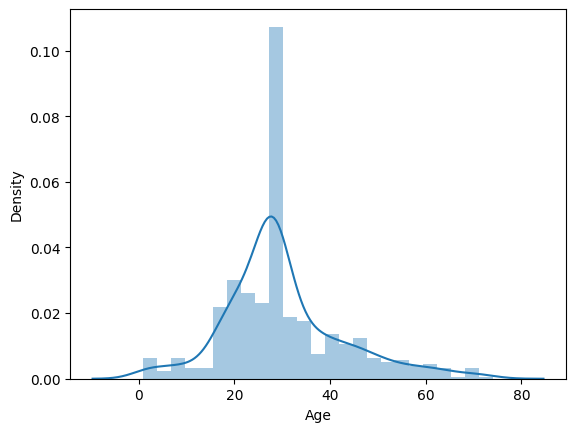

In [28]:
sns.distplot(survived_0['Age'])
plt.show()
## checking distribution of age in not survived data set

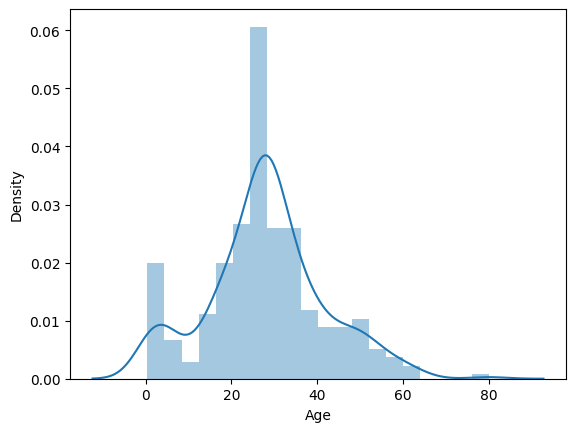

In [29]:
sns.distplot(survived_1['Age'])
plt.show()
## checking distribution of age in survived dataset

young persons are survived more (age group between 20-40)

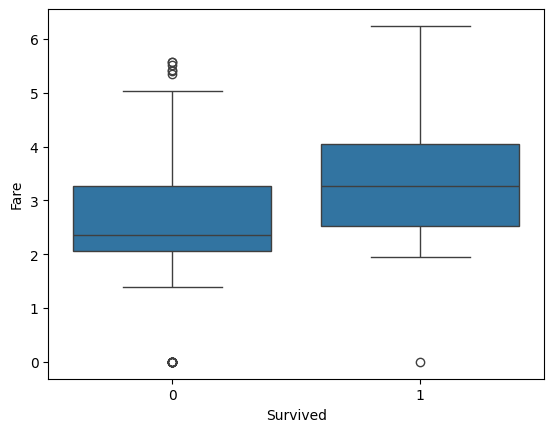

In [30]:
sns.boxplot(x='Survived',y='Fare',data=titanic)
plt.show()
## checking survival rate on basis of fare

those who are survived paid more fares

# creating dummy variables

In [32]:
Pclass_dummy = pd.get_dummies(titanic['Pclass'],prefix='Pclass',drop_first=True)
Pclass_dummy.head()
## creating dummy variables for pclass



,Pclass_2,Pclass_3
0,False,True
1,False,False
2,False,True
3,False,False
4,False,True


In [33]:
## joing dummy variables
titanic = pd.concat([titanic,Pclass_dummy],axis=1)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Alone,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,1.981001,S,1,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,4.266662,C,1,False,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,2.070022,S,0,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,3.972177,S,1,False,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,2.085672,S,0,False,True


In [34]:
titanic.drop('Pclass',axis=1,inplace=True)
## as there is no use of pclass after joining the columns that contains dummy variables  for pclass

In [36]:
Embarked_dummy = pd.get_dummies(titanic['Embarked'],drop_first=True)
Embarked_dummy.head()
## creating dummy variables for embarked and dropping first column

,Q,S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True


In [37]:
titanic = pd.concat([titanic,Embarked_dummy],axis=1)
titanic.drop('Embarked',axis=1,inplace=True)
## joining dummy variables

In [38]:
titanic.head()
## checking head of the data set after joining dummy variables

,PassengerId,Survived,Name,Sex,Age,Ticket,Fare,Alone,Pclass_2,Pclass_3,Q,S
0,1,0,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,1.981001,1,False,True,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,4.266662,1,False,False,False,False
2,3,1,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,2.070022,0,False,True,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,3.972177,1,False,False,False,True
4,5,0,"Allen, Mr. William Henry",male,35.0,373450,2.085672,0,False,True,False,True


In [39]:
def sex_map(x):
    if x == 'male':
        return (1)
    elif x == 'female':
        return (0)
titanic['Sex'] = titanic['Sex'].apply(lambda x:sex_map(x))

## creating function for convert sex into binary values

Select variables needed for creating model.

In [40]:
titanic = titanic[['Survived','Sex','Age','Fare','Alone','Pclass_2','Pclass_3','Q','S']]

# Outliers Treatment

The most basic form of outlier detection is Extreme Value analysis. The key of this method is to determine the statistical tails of the underlying distribution of the variable and find the values at the extreme end of the tails.
If the variable is not normally distributed (not a Gaussian distribution), a general approach is to calculate the quantiles and then the inter-quartile range.
IQR (Inter quantiles range)= 75th quantile — 25th quantile
An outlier will be in the following upper and lower boundaries:

Upper Boundary = 75th quantile +(IQR * 1.5)
Lower Boundary = 25th quantile — (IQR * 1.5)
Or for extreme cases:
Upper Boundary = 75th quantile +(IQR * 3)
Lower Boundary = 25th quantile — (IQR * 3)
If the data point is above the upper boundary or below the lower boundary, it can be considered as an outlier.

For more information on outliers treatment and detection check the following link : [https://medium.com/@swethalakshmanan14/outlier-detection-and-treatment-a-beginners-guide-c44af0699754](http://)

In [41]:
## First, let's calculate the Inter Quantile Range for our dataset,
IQR = titanic.Age.quantile(0.75) - titanic.Age.quantile(0.25)
## Using the IQR, we calculate the upper boundary using the formulas mentioned above for age
upper_limit = titanic.Age.quantile(0.75) + (IQR * 1.5)
upper_limit_extreme = titanic.Age.quantile(0.75) + (IQR * 3)
upper_limit, upper_limit_extreme


(54.5, 74.0)

In [44]:
## Now, let’s see the ratio of data points above the upper limit & extreme upper limit. ie, the outliers.
total = float(titanic.shape[0])
print('Total Passenger: {}'.format(titanic.Age.shape[0]/total))
print('Passenger those age > 54.5: {}'.format(titanic[titanic.Age>54.5].shape[0]/total))
print('passenger those age > 74.0: {}'.format(titanic[titanic.Age>74.0].shape[0]/total))

Total Passenger: 1.0
Passenger those age > 54.5: 0.04611923509561305
passenger those age > 74.0: 0.0011248593925759281


In [45]:
## hence replace more than 54.5 age values with age_median

titanic['Age'] = titanic['Age'].apply(lambda x:age_median if x>54.5 else x)

In [46]:
## let's define lower boundary of age

lower_limit = titanic.Age.quantile(0.25) - (IQR * 1.5)
lower_limit_extreme = titanic.Age.quantile(0.25) - (IQR * 3)
lower_limit, lower_limit_extreme

(2.5, -17.0)

In [47]:
## Now, let’s see the ratio of data points above the upper limit & extreme upper limit. ie, the outliers.
total = float(titanic.shape[0])
print('Total Passenger: {}'.format(titanic.Age.shape[0]/total))
print('Passenger those age < 2.5: {}'.format(titanic[titanic.Age<2.5].shape[0]/total))
print('passenger those age < -17.0: {}'.format(titanic[titanic.Age<-17.0].shape[0]/total))

Total Passenger: 1.0
Passenger those age < 2.5: 0.02699662542182227
passenger those age < -17.0: 0.0


In [48]:
## hence replace less than 2.5 age values with age_median

titanic['Age'] = titanic['Age'].apply(lambda x:age_median if x<2.5 else x)

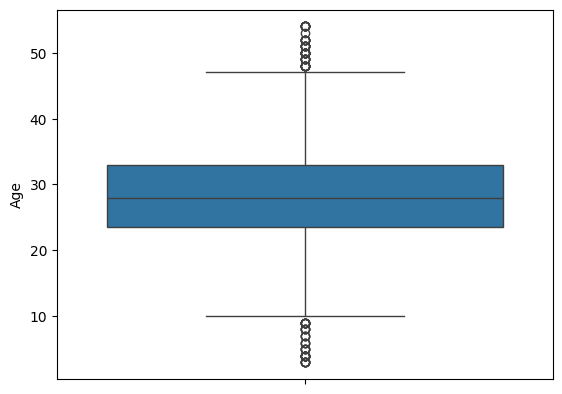

In [49]:
sns.boxplot(titanic['Age'])
plt.show()
## check distribution of Age after replacing outliers

In [50]:
## First, let's calculate the Inter Quantile Range for our dataset,
IQR_fare = titanic.Fare.quantile(0.75) - titanic.Fare.quantile(0.25)
## Using the IQR, we calculate the upper boundary using the formulas mentioned above for age
upper_limit_fare = titanic.Fare.quantile(0.75) + (IQR_fare * 1.5)
upper_limit_extreme_fare = titanic.Fare.quantile(0.75) + (IQR_fare * 3)
upper_limit_fare, upper_limit_extreme_fare


(5.485471552418255, 7.536955900351363)

In [51]:
## Now, let’s see the ratio of data points above the upper limit & extreme upper limit. ie, the outliers.
total = float(titanic.shape[0])
print('Total Passenger: {}'.format(titanic.Fare.shape[0]/total))
print('Passenger those fare > 6.213966625918822: {}'.format(titanic[titanic.Fare>6.213966625918822].shape[0]/total))
print('passenger those fare > 8.700333209612108: {}'.format(titanic[titanic.Fare>8.700333209612108].shape[0]/total))

Total Passenger: 1.0
Passenger those fare > 6.213966625918822: 0.003374578177727784
passenger those fare > 8.700333209612108: 0.0


In [52]:
fare_median = titanic['Fare'].median()
titanic['Fare'] = titanic['Fare'].apply(lambda x:fare_median if x>6.213966625918822 else x)

In [53]:
## let's define lower boundary of Fare

lower_limit_fare = titanic.Fare.quantile(0.25) - (IQR_fare * 1.5)
lower_limit_extreme_fare = titanic.Fare.quantile(0.25) - (IQR_fare * 3)
lower_limit_fare, lower_limit_extreme_fare

(0.014846624596632108, -2.0366377233364763)

In [54]:
## Now, let’s see the ratio of data points above the upper limit & extreme upper limit. ie, the outliers.
total = float(titanic.shape[0])
print('Total Passenger: {}'.format(titanic.Fare.shape[0]/total))
print('Passenger those fare < -0.4163442639299415: {}'.format(titanic[titanic.Fare<-0.4163442639299415].shape[0]/total))
print('passenger those fare < -2.9027108476232275: {}'.format(titanic[titanic.Fare<-2.9027108476232275].shape[0]/total))

Total Passenger: 1.0
Passenger those fare < -0.4163442639299415: 0.0
passenger those fare < -2.9027108476232275: 0.0


* No outliers spotted in lower range of Fare.

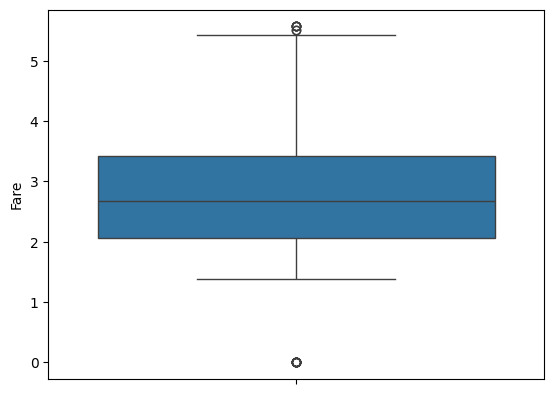

In [55]:
sns.boxplot(titanic['Fare'])
plt.show()
## check distribution of fare after replacing outliers

# Model Build

Divide data into x train and y train

In [56]:
y_train = titanic.pop('Survived')
X_train = titanic

Fit one default decision tree and interpret the accuracy.

In [57]:
import sklearn
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=2,random_state=10).fit(X_train,y_train)

In [58]:
## check accuracy score with default decision tree
from sklearn.metrics import accuracy_score
score_default = accuracy_score(y_train,dt.predict(X_train))
score_default

0.7862767154105736

**Ada Boost**

AdaBoost is one of the first boosting algorithms to be adapted in solving practices. Adaboost helps you combine multiple “weak classifiers” into a single “strong classifier”.

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
estm = list(range(1,500,3))
acc_score = []
for i in estm:
    ada = AdaBoostClassifier(base_estimator=dt,n_estimators=i,random_state=50).fit(X_train,y_train)
    pred = ada.predict(X_train)
    scores = accuracy_score(y_train,pred)
    acc_score.append(scores)


## created different estimators of ensembles and produce different accuracy score for each ensemble .

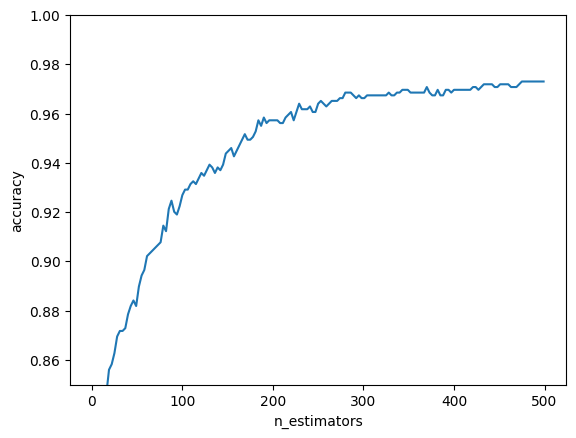

In [60]:
plt.plot(estm,acc_score)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim([0.85, 1])
plt.show()
## plotted number of estimators and accuracy score

If we keep increasing the number of estimators total error will become 0 and model will became overfit.

In [61]:
## let's make one final model

ada_final = AdaBoostClassifier(base_estimator=dt,n_estimators=50,random_state=100).fit(X_train,y_train)

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_train,ada_final.predict(X_train)))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       549
           1       0.87      0.81      0.84       340

    accuracy                           0.88       889
   macro avg       0.88      0.87      0.88       889
weighted avg       0.88      0.88      0.88       889



Let's prepare test data by removing outliers and imputing missing values for fit our model and do predict.

In [63]:
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [64]:
titanic_test.isnull().sum() ## check for null values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [65]:
## impute Age using age_median

titanic_test['Age'].fillna(age_median,inplace=True)

## log transformation of fare

titanic_test['Fare'] = titanic_test['Fare'].map(lambda x: np.log(x) if x>0 else 0)

In [66]:
## convert sex into numerical value

titanic_test['Sex'] = titanic_test['Sex'].apply(lambda x:sex_map(x))

## outliers treatment

titanic_test['Age'] = titanic_test['Age'].apply(lambda x:age_median if x>54.5 else x)

In [67]:
## outlier treatment

titanic_test['Age'] = titanic_test['Age'].apply(lambda x:age_median if x<2.5 else x)

titanic_test['Fare'] = titanic_test['Fare'].apply(lambda x:fare_median if x>6.213966625918822 else x)

In [68]:
## creating alone column

titanic_test['Alone'] = titanic_test.apply(alone,axis=1)

In [69]:
Embarked_dummy_test = pd.get_dummies(titanic_test['Embarked'],drop_first=True) ## creating dummy for test


In [70]:
titanic_test = pd.concat([titanic_test,Embarked_dummy_test],axis=1) ## joining dummy set

In [71]:
## creating dummy for pclass

Pclass_dummy_test = pd.get_dummies(titanic_test['Pclass'],prefix='Pclass',drop_first=True)

In [72]:
titanic_test = pd.concat([titanic_test,Pclass_dummy_test],axis=1) ## joining dummy set

In [73]:
test_cols = list(X_train.columns) ## required columns for fitting model

In [74]:
X_test = titanic_test[test_cols]

In [75]:
titanic_test['Survived'] = ada_final.predict(X_test) ## predicted survival using our model on test data

In [76]:
titanic_res = titanic_test[['PassengerId','Survived']]


In [77]:
titanic_res.to_csv("Submission_titanic.csv",index=False) ## final submission file